<a href="https://colab.research.google.com/github/Heoquixote/Machine_Learning/blob/main/Movie_recommend_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat' rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python') rating_df.head()

In [2]:
movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
rating_df

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [5]:
movie_df

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


'title/'genre'를 각각 나눠야 추천하기 용이하겠다 생각함

In [6]:
movie_name = []
movie_year = []
for i in range(0,3883):
  movie_name.append(movie_df['title'][i].split('(')[0][:-1])
  movie_year.append(movie_df['title'][i].split('(')[1][:-1])

In [7]:
#genre가 최대 6개까지 존재

genre_1 = []
genre_2 = []
genre_3 = []
genre_4 = []
genre_5 = []
genre_6 = []
genre_7 = []

for i in range(0,3883):
  genre_1.append(movie_df['genre'][i].split('|')[0])
  try : genre_2.append(movie_df['genre'][i].split('|')[1])
  except: genre_2.append('')
  try : genre_3.append(movie_df['genre'][i].split('|')[2])
  except: genre_3.append('')
  try : genre_4.append(movie_df['genre'][i].split('|')[3])
  except: genre_4.append('') 
  try : genre_5.append(movie_df['genre'][i].split('|')[4])
  except: genre_5.append('')  
  try : genre_6.append(movie_df['genre'][i].split('|')[5])
  except: genre_6.append('')
  try : genre_7.append(movie_df['genre'][i].split('|')[6])
  except: genre_7.append('')   

In [8]:
#판다스로 변환
col1 = pd.DataFrame(movie_name)
col2 = pd.DataFrame(movie_year)
col3 = pd.DataFrame(genre_1)
col4 = pd.DataFrame(genre_2)
col5 = pd.DataFrame(genre_3)
col6 = pd.DataFrame(genre_4)
col7 = pd.DataFrame(genre_5)
col8 = pd.DataFrame(genre_6)

In [9]:
movie_df = movie_df.drop(columns= ['title' , 'genre'])
movie_df = pd.concat([movie_df,col1,col2,col3,col4,col5,col6,col7,col8],axis=1)
movie_df.columns = ['movie_id','movie_name','movie_year','genre1','genre2','genre3','genre4','genre5','genre6']

In [20]:
movie_df

,movie_id,movie_name,movie_year,genre1,genre2,genre3,genre4,genre5,genre6
0,1,Toy Story,1995,Animation,Children's,Comedy,,,
1,2,Jumanji,1995,Adventure,Children's,Fantasy,,,
2,3,Grumpier Old Men,1995,Comedy,Romance,,,,
3,4,Waiting to Exhale,1995,Comedy,Drama,,,,
4,5,Father of the Bride Part II,1995,Comedy,,,,,
...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,2000,Comedy,,,,,
3879,3949,Requiem for a Dream,2000,Drama,,,,,
3880,3950,Tigerland,2000,Drama,,,,,
3881,3951,Two Family House,2000,Drama,,,,,


In [25]:
rating_df

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [34]:
id_rating = pd.pivot_table(data=rating_df, values='rating',index='movie_id',aggfunc=np.mean)

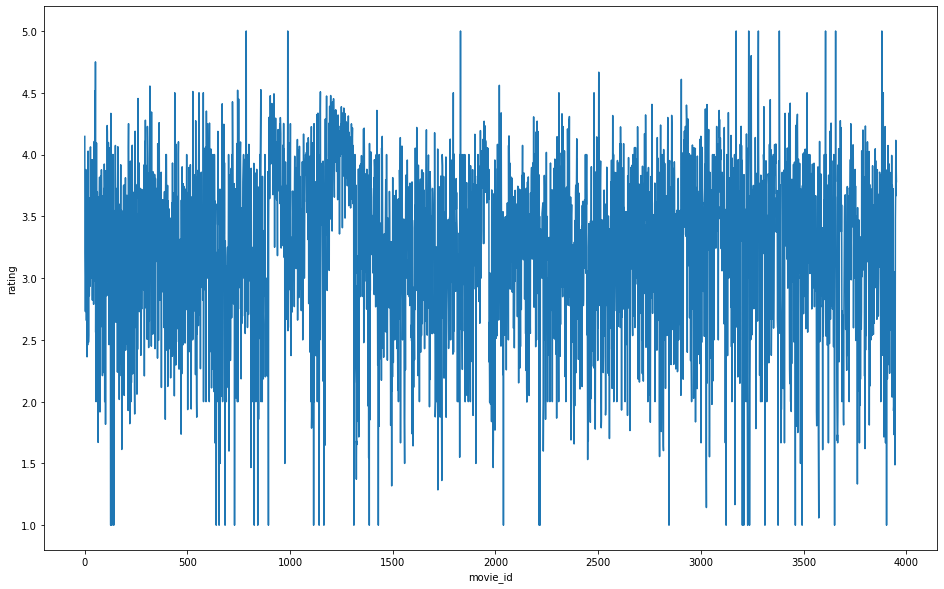

In [37]:
# movie id 별 Rating 분포

plt.figure(figsize=(16, 10))
sns.lineplot(data=id_rating, x="movie_id", y="  rating", ci=None)
plt.show()

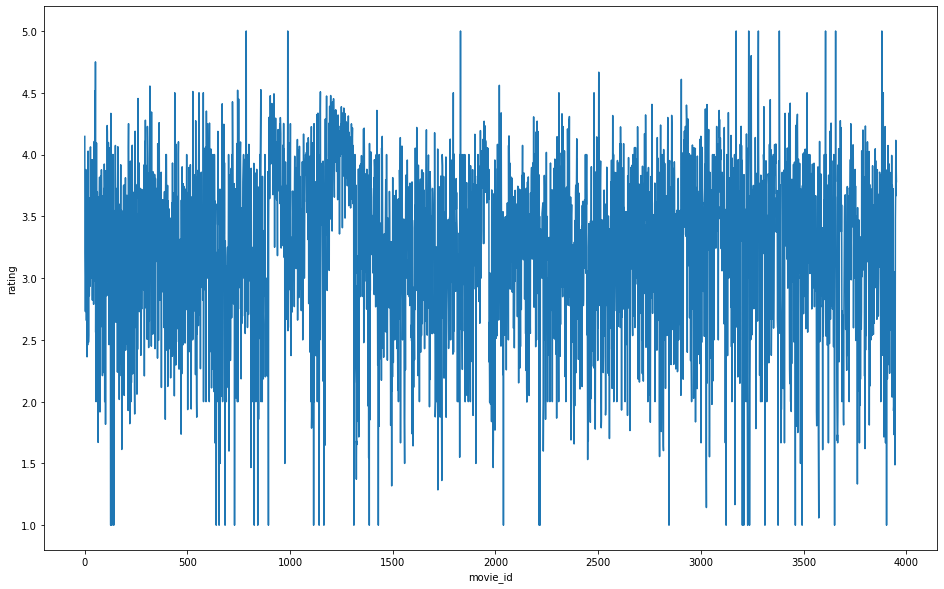

In [11]:
# movie id 별 Rating 분포

plt.figure(figsize=(16, 10))
sns.lineplot(data=rating_df, x="movie_id", y="rating", ci=None)
plt.show()